In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/new_data/real_size.csv
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R14-0324a ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R16-0398A ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_1202184 D5 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R13-0019 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R12-0315 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R13-0494a ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R14-0118 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R16-0330A ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R13-0163 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R14-0323 ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R13-0065A ICM_Mask.bmp
/kaggle/input/dataset/new_data/valid/GT_ICM/Blast_PCRM_R13-0074B ICM_Mask.bmp
/kaggle/input/dataset/n

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from glob import glob
import os
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU


2025-05-31 21:40:02.545600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748727603.009063      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748727603.137044      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
" Seeding """
np.random.seed(42)
tf.random.set_seed(42)


In [5]:
SIZE=256
def read_image_tf(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask_tf(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (SIZE, SIZE))
    y[y != 0] = 255
    y = y / 255.0
    y = (y > 0.5).astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path, y_path):
    def _parse(x_path, y_path):
        x = read_image_tf(x_path)
        y = read_mask_tf(y_path)
        return x, y

    x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float32, tf.float32])
    x.set_shape([SIZE, SIZE, 3])
    y.set_shape([SIZE, SIZE, 1])
    return x, y

def tf_dataset(x_paths, y_paths, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [6]:
def iou(y_true, y_pred):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=False),
    TensorBoard()

]

In [8]:

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
weight_decay=1e-8
def conv_block(x, filters, dropout=False):
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.5)(x)

    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # Apply dropout in encoder 4
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [9]:
train_y = '/kaggle/input/dataset/new_data/train/GT_ICM'
train_x = '/kaggle/input/dataset/new_data/train/images'
test_y = '/kaggle/input/dataset/new_data/test/GT_ICM'
test_x = '/kaggle/input/dataset/new_data/test/images'
valid_y = '/kaggle/input/dataset/new_data/valid/GT_ICM'
valid_x = '/kaggle/input/dataset/new_data/valid/images'

train_images = sorted(glob(os.path.join(train_x, "*.bmp")))
train_masks  = sorted(glob(os.path.join(train_y, "*.bmp")))

test_images = sorted(glob(os.path.join(test_x, "*.bmp")))
test_masks  = sorted(glob(os.path.join(test_y, "*.bmp")))

valid_images = sorted(glob(os.path.join(valid_x, "*.bmp")))
valid_masks  = sorted(glob(os.path.join(valid_y, "*.bmp")))

# Create datasets
train_dataset = tf_dataset(train_images, train_masks, batch_size=16)
test_dataset  = tf_dataset(test_images, test_masks, batch_size=16,shuffle=False)
valid_dataset = tf_dataset(valid_images, valid_masks, batch_size=16, shuffle=False)
print("Number of training samples:", len(train_images))
print("Number of validation samples:", len(valid_images))
print("Number of testing samples:", len(test_images))

metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]

I0000 00:00:1748727622.259767      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748727622.260531      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Number of training samples: 995
Number of validation samples: 25
Number of testing samples: 25


In [10]:
def channel_attention(x, ratio=2, name_prefix="attention"):
    channel = x.shape[-1]
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', name=f"{name_prefix}_dense1")
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', name=f"{name_prefix}_dense2")

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    out = layers.Add(name=f"{name_prefix}_add")([avg_out, max_out])
    attention = layers.Activation('sigmoid', name=f"{name_prefix}_sigmoid")(out)

    scaled = layers.Multiply(name=f"{name_prefix}_multiply")([x, attention])
    out = layers.Add(name=f"{name_prefix}_final_add")([scaled, x])

    return out, attention, scaled


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Ensure tf is imported

# Get a test sample (image, mask) from the validation dataset
sample = next(iter(valid_dataset))
sample_img = sample[0][0]  # (H, W, C)
sample_mask = sample[1][0]  # (H, W, 1) or (H, W)

# Expand dims for prediction
sample_img_exp = tf.expand_dims(sample_img, axis=0)  # (1, H, W, C)

In [12]:

import tensorflow as tf
from tensorflow.keras import layers

def dual_pathway_spatial_attention(x_l, x_h, out_channels,name_prefix="attention"):
    """
    Dual-pathway AG block: spatial attention for decoder stage s.

    Args:
        x_h: high-level feature map (upsampled from decoder)
        x_l: low-level feature map (from encoder)
        out_channels: number of output channels after ΦC conv (e.g., 64, 32, 16)

    Returns:
        Calibrated feature map after dual-pathway attention.
    """
    def single_path_attention(x_l, x_h):
    # Combine high-level and low-level features
      theta_x_l = layers.Conv2D(out_channels, (1, 1), padding='same')(x_l)
      phi_x_h = layers.Conv2D(out_channels, (1, 1), padding='same')(x_h)
      add = layers.Add()([theta_x_l, phi_x_h])
      act = layers.Activation('relu')(add)
      attention = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act)
      out = layers.Multiply()([x_l, attention])  # x_l · α

      return out


    # First AG pathway
    ag1 = single_path_attention(x_l, x_h)

    # Second AG pathway (can be made slightly different if needed)
    ag2 = single_path_attention(x_l, x_h)

    # Concatenate both pathways (along channel axis)
    concat = layers.Concatenate(axis=-1)([ag1, ag2])

    # Apply ΦC (1x1 conv + BN + ReLU)
    conv = layers.Conv2D(out_channels, (1, 1), padding='same' , use_bias=False)(concat)
    bn = layers.BatchNormalization()(conv)
    out = layers.Activation('relu',name=f"{name_prefix}_outskip")(bn)

    return out


In [13]:
from tensorflow.keras import layers, backend as K
import tensorflow as tf

def SA1_non_local_attention(x, inter_channels=64,name_prefix="attention"):
    input_channels = x.shape[-1]
    H, W = x.shape[1], x.shape[2]  # Capture symbolic H and W

    # Step 1: Reduce channels
    x_0   = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_00  = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_000 = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)

    # Step 2: Flatten (B, H, W, C) → (B, H*W, C)
    def reshape_for_attention(y):
        return tf.reshape(y, (tf.shape(y)[0], -1, inter_channels))  # (B, HW, C)

    x_theta = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_0)
    x_phi   = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_00)
    x_g     = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_000)

    # Step 3: Attention weights
    attention_scores = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1], transpose_b=True),
        output_shape=(None, None, None)
    )([x_theta, x_phi])

    attention = layers.Activation('softmax')(attention_scores)

    # Step 4: Apply attention: α · g
    x_att = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1]),
        output_shape=(None, None, inter_channels)
    )([attention, x_g])

    # Step 5: Reshape back to (B, H, W, C)
    def reshape_back(y):
        return tf.reshape(y, (-1, H, W, inter_channels))

    x_att_reshaped = layers.Lambda(reshape_back, output_shape=(H, W, inter_channels))(x_att)

    # Step 6: Project back to input channels
    x_out = layers.Conv2D(input_channels, (1, 1), padding='same', use_bias=False)(x_att_reshaped)
    x_out = layers.BatchNormalization()(x_out)
    final=layers.Add(name=f"{name_prefix}_final_add")([x_out, x])
    return final,x_out


In [14]:
def decoder_blockspc(x,skip, filters,name_prefix="decoder"):
    x = conv_block(x, filters*2)
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    skipatt=dual_pathway_spatial_attention(skip,x,filters,name_prefix=f"{name_prefix}_dualattention")
    x = layers.Concatenate(axis=-1)([x, skipatt])
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,skipatt


In [15]:
def decoder_blocknlbc(x, skip, filters,name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x,f = SA1_non_local_attention(x,name_prefix=f"{name_prefix}_nlbattention")
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,f


In [16]:
def scale_attention_module(features,name_prefix="attention"):
    """
    Paper-faithful Scale Attention Module (CA-Net) with symbolic shape fix.
    Args:
        features: list of decoder feature maps from 4 different scales (d1 to d4)
    Returns:
        Final enhanced feature map (B, H, W, 4)
    """
    H, W = features[3].shape[1], features[3].shape[2]  # symbolic-safe shape

    # 1. Resize all feature maps to same shape
    resized = [layers.Resizing(H, W, interpolation='bilinear')(f) for f in features]

    # 2. Compress to 1 channel per scale
    compressed = [layers.Conv2D(1, (1, 1), padding='same')(f) for f in resized]

    # 3. Concatenate → F̂ (B, H, W, 4)
    F_hat = layers.Concatenate(axis=-1)(compressed)
    shared_dense_one = layers.Dense(16 , activation='relu', kernel_initializer='he_normal')
    shared_dense_two = layers.Dense(4, kernel_initializer='he_normal')
    # 4. Scale-wise attention γ
    gap = layers.GlobalAveragePooling2D()(F_hat)
    gmp = layers.GlobalMaxPooling2D()(F_hat)
    gap = layers.Reshape((1, 1, 4))(gap)
    gmp = layers.Reshape((1, 1, 4))(gmp)
    gap = shared_dense_two(shared_dense_one(gap))
    gmp = shared_dense_two(shared_dense_one(gmp))
    gamma = layers.Add()([gap, gmp])
    gamma = layers.Activation('sigmoid')(gamma)  # (B, 1, 1, 4)

    F_gamma = layers.Multiply()([F_hat, gamma])  # (B, H, W, 4)

    # 5. Pixel-wise scale attention γ*
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(F_gamma)
    gamma_star = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(x)


    # 6. Final residual + fused output
    out = layers.Add(name=f"{name_prefix}_final")([
        layers.Multiply()([F_gamma, gamma_star]),
        layers.Multiply()([F_hat, gamma]),
        F_hat
    ])
    return out


In [17]:
def build_unettotale(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)
    d1,vec,ch1,SA1 = decoder_blocknlbc(b1, s4, 512,name_prefix="decoder1")
    d2,vec,ch2,SA2 = decoder_blockspc(d1, s3, 256,name_prefix="decoder2")
    d3,vec,ch3,SA3 = decoder_blockspc(d2, s2, 128,name_prefix="decoder3")
    d4,vec,ch4,SA4 = decoder_blockspc(d3, s1, 64,name_prefix="decoder4")
    la_output = scale_attention_module([d1, d2, d3, d4],name_prefix="scaler")  # returns enhanced feature map

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid",name="segmentation_output")(la_output)

    return Model(inputs=inputs, outputs=outputs)

In [18]:
# Now build and compile model like you did
input_shape = ((SIZE, SIZE, 3))
modelicm_totale = build_unettotale(input_shape)
modelicm_totale.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [20]:
layer_names = [
    "decoder1_nlbattention_final_add",
    "decoder1_channelattention_final_add",
    "decoder2_dualattention_outskip",
    "decoder2_channelattention_final_add",
    "decoder3_dualattention_outskip",
    "decoder3_channelattention_final_add",
    "decoder4_dualattention_outskip",
    "decoder4_channelattention_final_add",
    "scaler_final"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelicm_totale.input,
                                   outputs=[modelicm_totale.get_layer(name).output for name in layer_names])



In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data, freq=5):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data
        self.freq = freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq != 0:
            return  # Skip this epoch

        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle(f'Feature Maps - Epoch {epoch + 1}')
        plt.tight_layout()
        plt.show()


In [22]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset,freq=5)


Epoch 1/300


I0000 00:00:1748727673.368280     103 service.cc:148] XLA service 0x7f619c003a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748727673.370058     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748727673.370085     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748727677.942709     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-31 21:41:25.777841: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest

62/63 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.7719 - dice_coef: 0.3869 - iou: 0.2717 - loss: 0.6131 - precision: 0.2453 - recall: 0.7732

E0000 00:00:1748727951.452021     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748727951.675160     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748727959.025662     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748727959.331836     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748727965.899091     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7734 - dice_coef: 0.3897 - iou: 0.2741 - loss: 0.6104 - precision: 0.2471 - recall: 0.7735

E0000 00:00:1748728023.108986     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748728023.348787     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


63/63 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.7749 - dice_coef: 0.3923 - iou: 0.2765 - loss: 0.6078 - precision: 0.2489 - recall: 0.7738 - val_accuracy: 0.9166 - val_dice_coef: 0.0762 - val_iou: 1.6047e-20 - val_loss: 0.9238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9628 - dice_coef: 0.7681 - iou: 0.6271 - loss: 0.2319 - precision: 0.7613 - recall: 0.7794 - val_accuracy: 0.9166 - val_dice_coef: 0.0032 - val_iou: 1.6047e-20 - val_loss: 0.9967 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9696 - dice_coef: 0.8155 - iou: 0.6915 - loss: 0.1845 - precision: 0.8024 - recall: 0.8310 - val_accuracy: 0.9166 - val_dice_coef: 0.0036 - val_iou: 0.0017 - val_loss: 0.9973 - val_precision: 0.8595 - val_recall: 0.0012 - learning_rate: 1.0000e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s

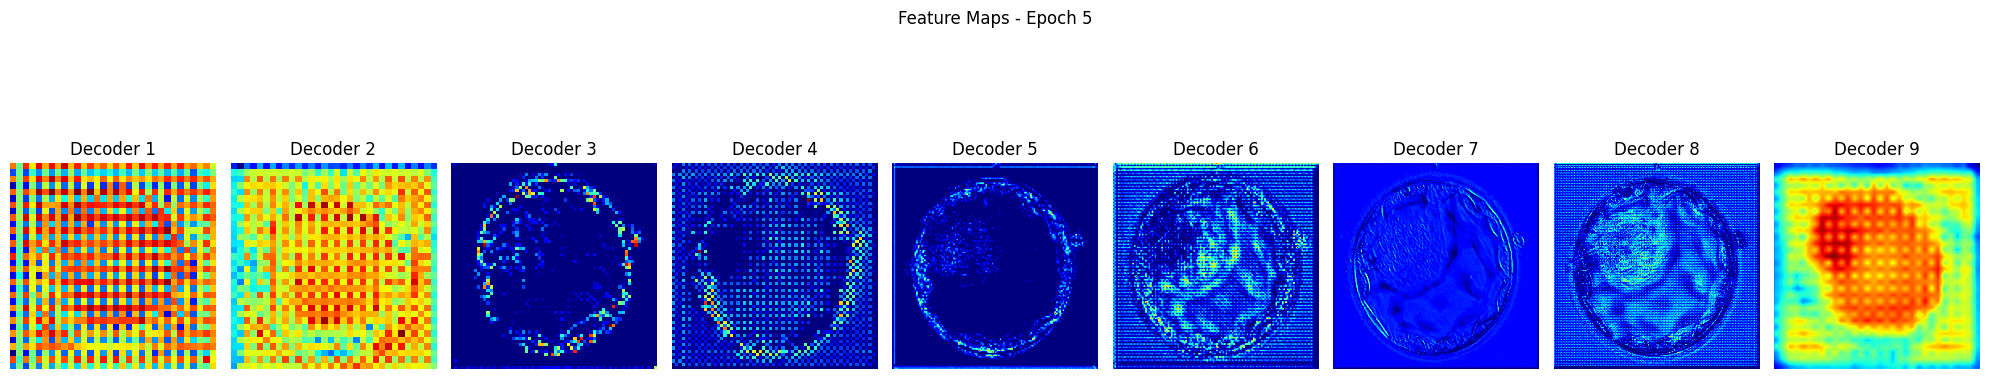

63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9745 - dice_coef: 0.8461 - iou: 0.7350 - loss: 0.1539 - precision: 0.8347 - recall: 0.8592 - val_accuracy: 0.9573 - val_dice_coef: 0.7067 - val_iou: 0.5480 - val_loss: 0.2821 - val_precision: 0.7924 - val_recall: 0.6613 - learning_rate: 1.0000e-04
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9757 - dice_coef: 0.8494 - iou: 0.7404 - loss: 0.1507 - precision: 0.8459 - recall: 0.8549 - val_accuracy: 0.9570 - val_dice_coef: 0.6781 - val_iou: 0.5129 - val_loss: 0.3222 - val_precision: 0.9033 - val_recall: 0.5423 - learning_rate: 1.0000e-04
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9777 - dice_coef: 0.8607 - iou: 0.7577 - loss: 0.1393 - precision: 0.8526 - recall: 0.8704 - val_accuracy: 0.9672 - val_dice_coef: 0.7830 - val_iou: 0.6442 - val_loss: 0.2209 - val_precision: 0.8902 - val_recall: 0.6927 - learning_rate: 1.0000e-04
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9801

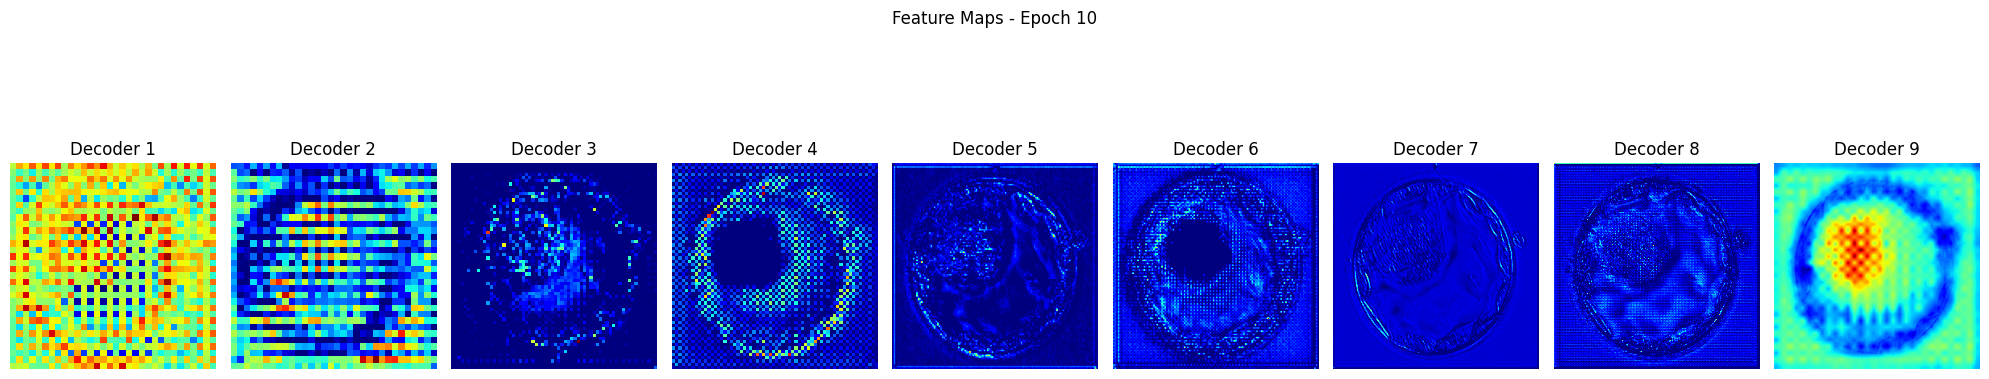

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9808 - dice_coef: 0.8807 - iou: 0.7883 - loss: 0.1194 - precision: 0.8821 - recall: 0.8809 - val_accuracy: 0.9751 - val_dice_coef: 0.8533 - val_iou: 0.7448 - val_loss: 0.1504 - val_precision: 0.8574 - val_recall: 0.8416 - learning_rate: 1.0000e-04
Epoch 11/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9820 - dice_coef: 0.8869 - iou: 0.7983 - loss: 0.1131 - precision: 0.8824 - recall: 0.8924 - val_accuracy: 0.9734 - val_dice_coef: 0.8332 - val_iou: 0.7142 - val_loss: 0.1681 - val_precision: 0.8790 - val_recall: 0.7892 - learning_rate: 1.0000e-04
Epoch 12/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9829 - dice_coef: 0.8946 - iou: 0.8114 - loss: 0.1054 - precision: 0.8966 - recall: 0.8935 - val_accuracy: 0.9755 - val_dice_coef: 0.8608 - val_iou: 0.7561 - val_loss: 0.1428 - val_precision: 0.8372 - val_recall: 0.8773 - learning_rate: 1.0000e-04
Epoch 13/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

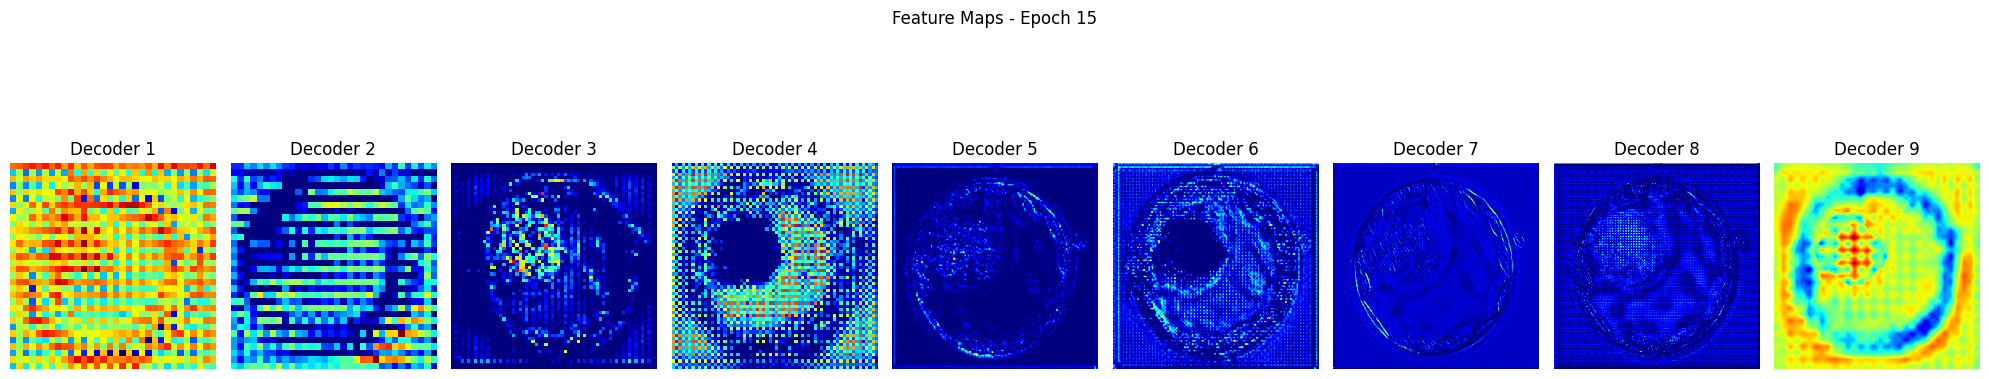

63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9852 - dice_coef: 0.9063 - iou: 0.8305 - loss: 0.0937 - precision: 0.9113 - recall: 0.9031 - val_accuracy: 0.9741 - val_dice_coef: 0.8431 - val_iou: 0.7297 - val_loss: 0.1633 - val_precision: 0.8845 - val_recall: 0.7931 - learning_rate: 1.0000e-04
Epoch 16/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9837 - dice_coef: 0.8989 - iou: 0.8178 - loss: 0.1011 - precision: 0.8992 - recall: 0.8994 - val_accuracy: 0.9765 - val_dice_coef: 0.8735 - val_iou: 0.7773 - val_loss: 0.1359 - val_precision: 0.8407 - val_recall: 0.8868 - learning_rate: 1.0000e-04
Epoch 17/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9865 - dice_coef: 0.9162 - iou: 0.8467 - loss: 0.0838 - precision: 0.9181 - recall: 0.9160 - val_accuracy: 0.9771 - val_dice_coef: 0.8679 - val_iou: 0.7675 - val_loss: 0.1382 - val_precision: 0.8729 - val_recall: 0.8494 - learning_rate: 1.0000e-04
Epoch 18/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9

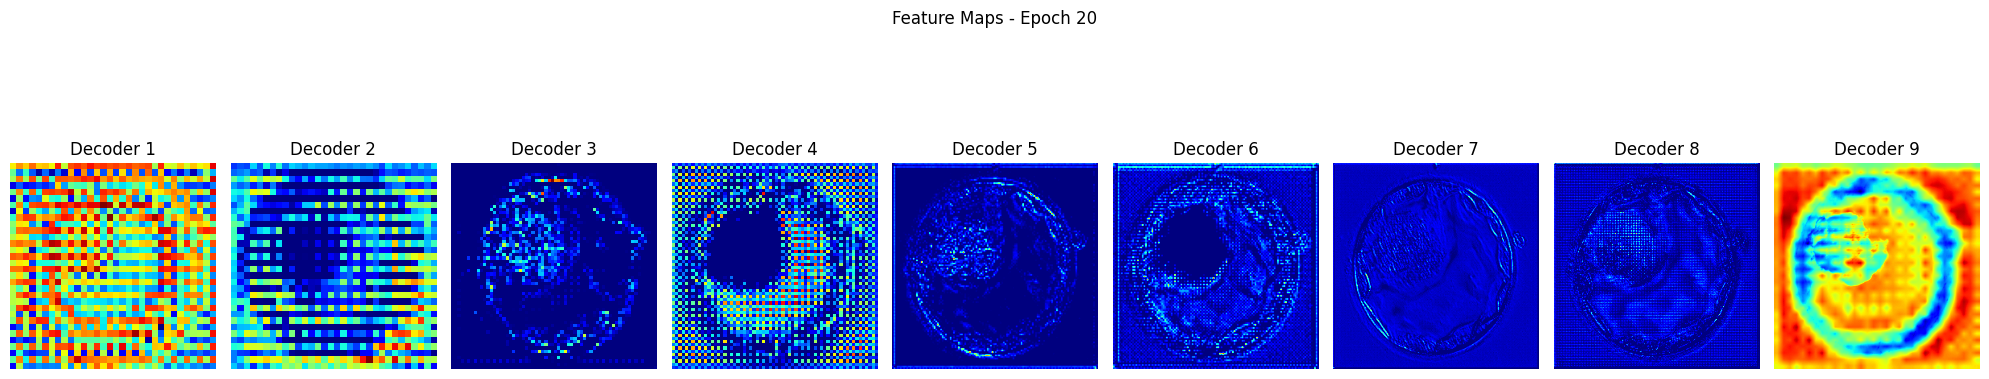

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9861 - dice_coef: 0.9133 - iou: 0.8417 - loss: 0.0867 - precision: 0.9242 - recall: 0.9029 - val_accuracy: 0.9745 - val_dice_coef: 0.8592 - val_iou: 0.7534 - val_loss: 0.1440 - val_precision: 0.8097 - val_recall: 0.9071 - learning_rate: 1.0000e-04
Epoch 21/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9842 - dice_coef: 0.9002 - iou: 0.8207 - loss: 0.0998 - precision: 0.9083 - recall: 0.8944 - val_accuracy: 0.9748 - val_dice_coef: 0.8694 - val_iou: 0.7700 - val_loss: 0.1378 - val_precision: 0.7959 - val_recall: 0.9384 - learning_rate: 1.0000e-04
Epoch 22/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9880 - dice_coef: 0.9262 - iou: 0.8637 - loss: 0.0738 - precision: 0.9310 - recall: 0.9213 - val_accuracy: 0.9768 - val_dice_coef: 0.8556 - val_iou: 0.7478 - val_loss: 0.1468 - val_precision: 0.9064 - val_recall: 0.8054 - learning_rate: 1.0000e-04
Epoch 23/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

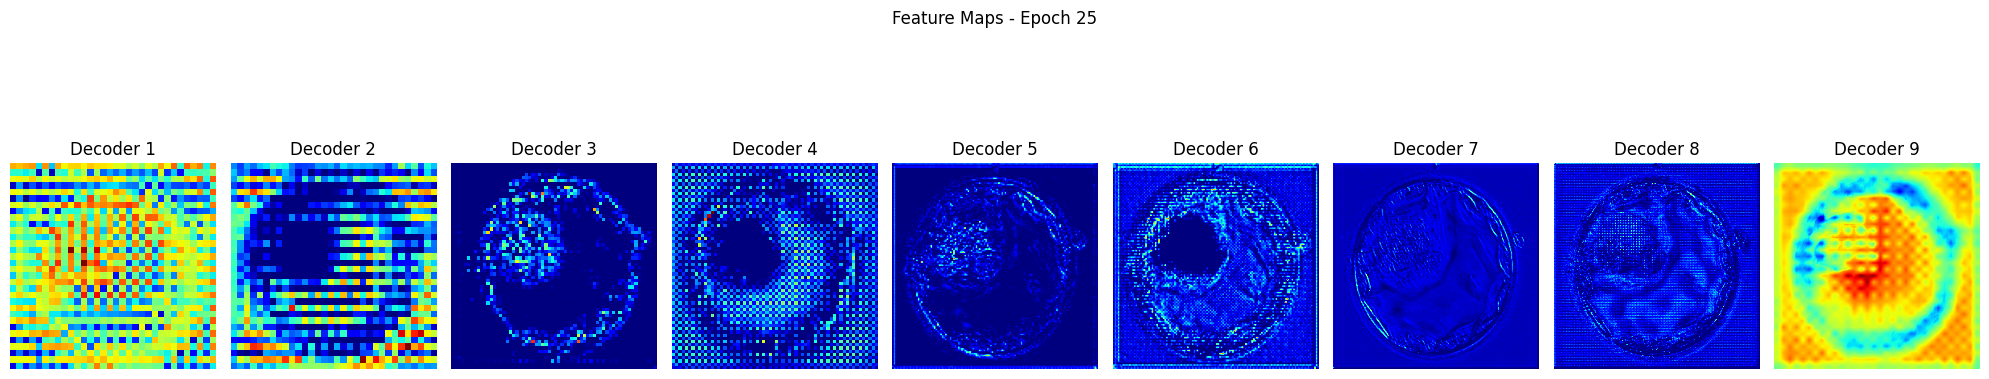

63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9894 - dice_coef: 0.9343 - iou: 0.8776 - loss: 0.0657 - precision: 0.9415 - recall: 0.9275 - val_accuracy: 0.9762 - val_dice_coef: 0.8616 - val_iou: 0.7576 - val_loss: 0.1441 - val_precision: 0.8705 - val_recall: 0.8403 - learning_rate: 1.0000e-04
Epoch 26/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9894 - dice_coef: 0.9342 - iou: 0.8773 - loss: 0.0658 - precision: 0.9389 - recall: 0.9300
Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9894 - dice_coef: 0.9341 - iou: 0.8773 - loss: 0.0658 - precision: 0.9389 - recall: 0.9300 - val_accuracy: 0.9774 - val_dice_coef: 0.8696 - val_iou: 0.7700 - val_loss: 0.1367 - val_precision: 0.8741 - val_recall: 0.8512 - learning_rate: 1.0000e-04
Epoch 27/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9902 - dice_coef: 0.9372 - iou: 0.8828 - loss: 0.0628 - precision: 0.9455 - recall: 0.9297 - val

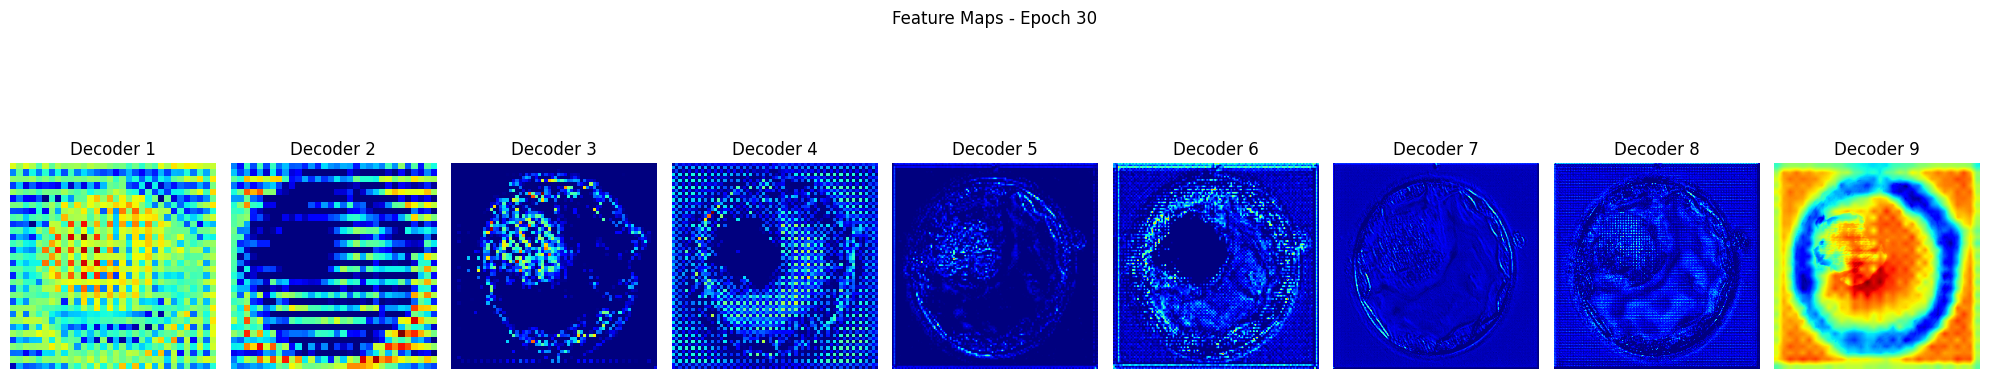

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9916 - dice_coef: 0.9470 - iou: 0.9000 - loss: 0.0530 - precision: 0.9509 - recall: 0.9433 - val_accuracy: 0.9781 - val_dice_coef: 0.8699 - val_iou: 0.7700 - val_loss: 0.1345 - val_precision: 0.8921 - val_recall: 0.8392 - learning_rate: 1.0000e-05
Epoch 31/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9910 - dice_coef: 0.9436 - iou: 0.8945 - loss: 0.0564 - precision: 0.9494 - recall: 0.9386 - val_accuracy: 0.9783 - val_dice_coef: 0.8735 - val_iou: 0.7759 - val_loss: 0.1316 - val_precision: 0.8826 - val_recall: 0.8532 - learning_rate: 1.0000e-05
Epoch 32/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9925 - dice_coef: 0.9530 - iou: 0.9108 - loss: 0.0470 - precision: 0.9559 - recall: 0.9506 - val_accuracy: 0.9781 - val_dice_coef: 0.8722 - val_iou: 0.7738 - val_loss: 0.1325 - val_precision: 0.8806 - val_recall: 0.8537 - learning_rate: 1.0000e-05
Epoch 33/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9

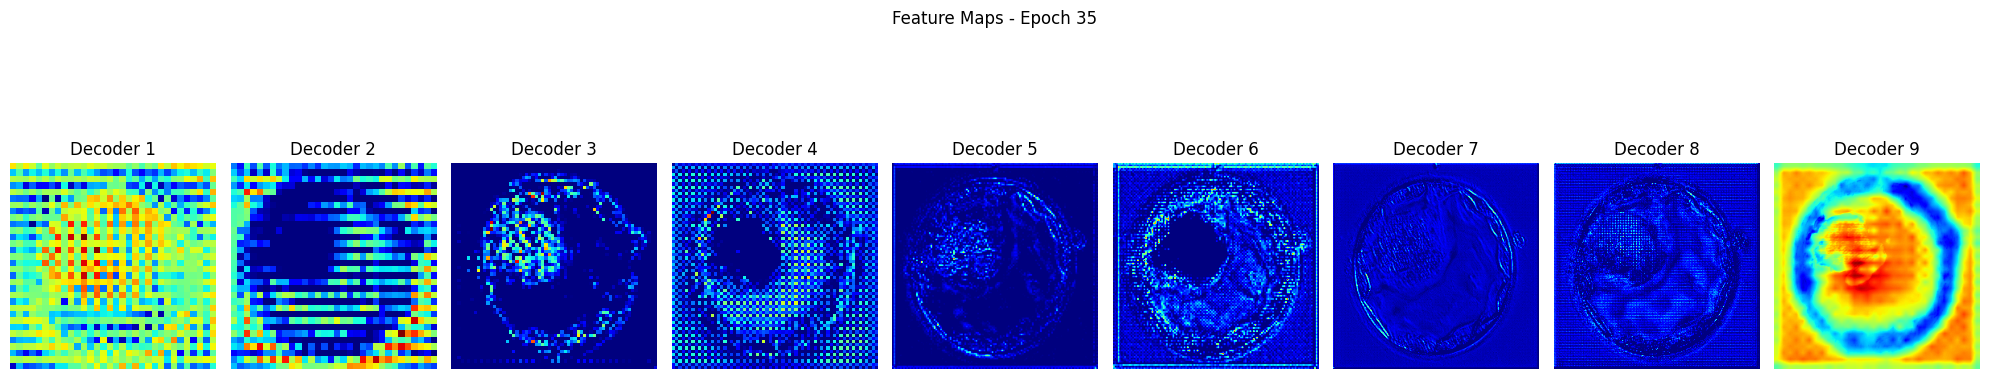

63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9925 - dice_coef: 0.9533 - iou: 0.9114 - loss: 0.0467 - precision: 0.9556 - recall: 0.9517 - val_accuracy: 0.9781 - val_dice_coef: 0.8747 - val_iou: 0.7780 - val_loss: 0.1312 - val_precision: 0.8728 - val_recall: 0.8636 - learning_rate: 1.0000e-05
Epoch 36/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9922 - dice_coef: 0.9508 - iou: 0.9070 - loss: 0.0492 - precision: 0.9562 - recall: 0.9467 - val_accuracy: 0.9781 - val_dice_coef: 0.8729 - val_iou: 0.7750 - val_loss: 0.1319 - val_precision: 0.8780 - val_recall: 0.8572 - learning_rate: 1.0000e-05
Epoch 37/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9928 - dice_coef: 0.9542 - iou: 0.9131 - loss: 0.0458 - precision: 0.9589 - recall: 0.9503
Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9928 - dice_coef: 0.9541 - iou: 0.9131 - loss: 0.0458 - precision: 0.9589 - recall: 0.9503 - val

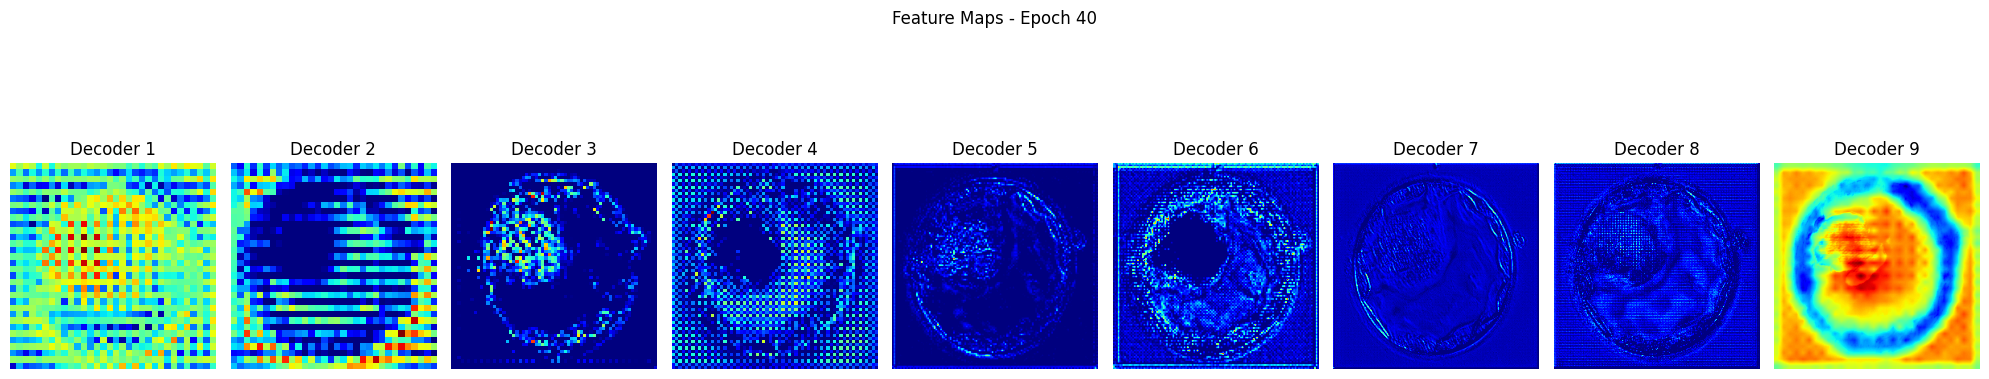

63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9930 - dice_coef: 0.9555 - iou: 0.9156 - loss: 0.0444 - precision: 0.9626 - recall: 0.9499 - val_accuracy: 0.9779 - val_dice_coef: 0.8713 - val_iou: 0.7724 - val_loss: 0.1332 - val_precision: 0.8755 - val_recall: 0.8570 - learning_rate: 1.0000e-06
Epoch 41/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9920 - dice_coef: 0.9508 - iou: 0.9071 - loss: 0.0491 - precision: 0.9581 - recall: 0.9437 - val_accuracy: 0.9779 - val_dice_coef: 0.8707 - val_iou: 0.7714 - val_loss: 0.1334 - val_precision: 0.8780 - val_recall: 0.8544 - learning_rate: 1.0000e-06
Epoch 42/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9934 - dice_coef: 0.9584 - iou: 0.9207 - loss: 0.0416 - precision: 0.9602 - recall: 0.9572 - val_accuracy: 0.9780 - val_dice_coef: 0.8714 - val_iou: 0.7727 - val_loss: 0.1329 - val_precision: 0.8754 - val_recall: 0.8578 - learning_rate: 1.0000e-06
Epoch 43/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

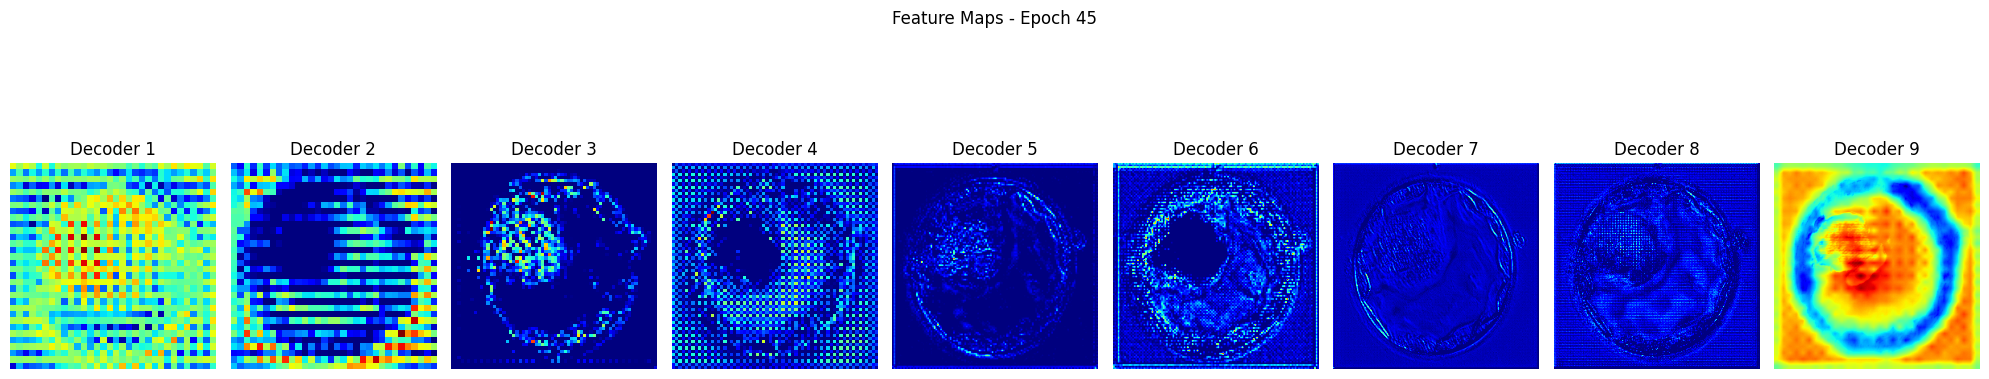

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9930 - dice_coef: 0.9566 - iou: 0.9174 - loss: 0.0434 - precision: 0.9614 - recall: 0.9523 - val_accuracy: 0.9778 - val_dice_coef: 0.8716 - val_iou: 0.7729 - val_loss: 0.1331 - val_precision: 0.8727 - val_recall: 0.8599 - learning_rate: 1.0000e-06
Epoch 46/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9927 - dice_coef: 0.9538 - iou: 0.9124 - loss: 0.0462 - precision: 0.9576 - recall: 0.9505 - val_accuracy: 0.9778 - val_dice_coef: 0.8705 - val_iou: 0.7712 - val_loss: 0.1340 - val_precision: 0.8740 - val_recall: 0.8570 - learning_rate: 1.0000e-06
Epoch 47/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9932 - dice_coef: 0.9571 - iou: 0.9184 - loss: 0.0429 - precision: 0.9606 - recall: 0.9545
Epoch 47: ReduceLROnPlateau reducing learning rate to 1e-07.
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9932 - dice_coef: 0.9570 - iou: 0.9182 - loss: 0.0429 - precision: 0.9606 - recall: 0.9545 - val_accuracy: 0.977

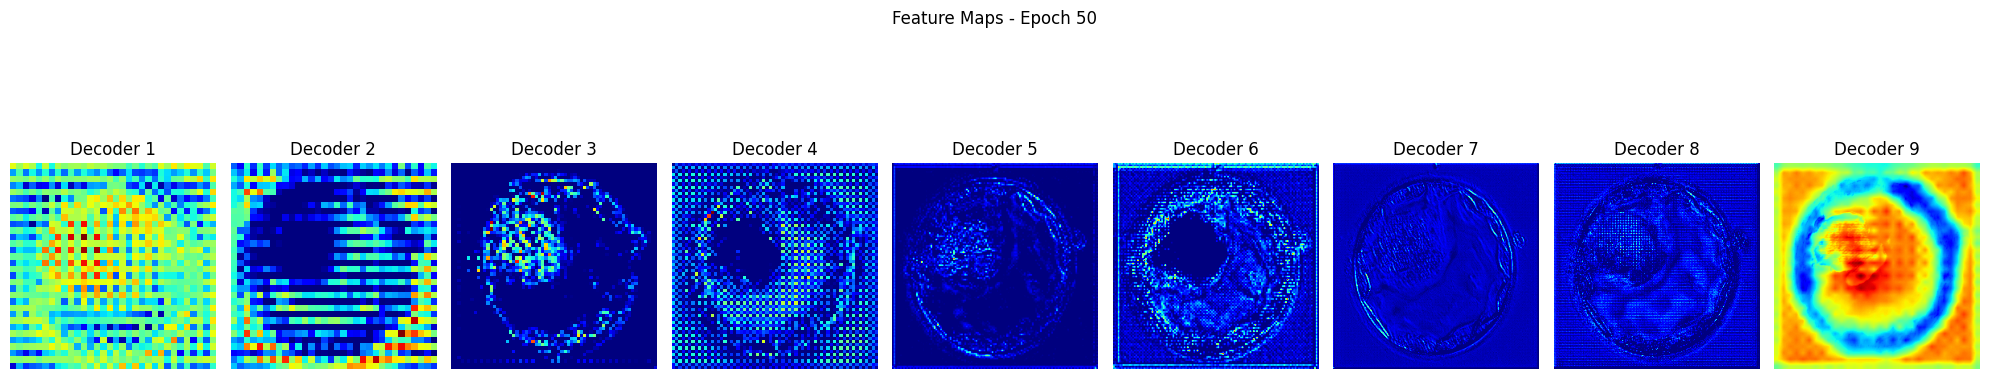

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9924 - dice_coef: 0.9530 - iou: 0.9112 - loss: 0.0470 - precision: 0.9586 - recall: 0.9479 - val_accuracy: 0.9778 - val_dice_coef: 0.8707 - val_iou: 0.7715 - val_loss: 0.1339 - val_precision: 0.8743 - val_recall: 0.8570 - learning_rate: 1.0000e-07
Epoch 51/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9927 - dice_coef: 0.9545 - iou: 0.9136 - loss: 0.0455 - precision: 0.9591 - recall: 0.9505 - val_accuracy: 0.9778 - val_dice_coef: 0.8708 - val_iou: 0.7717 - val_loss: 0.1338 - val_precision: 0.8742 - val_recall: 0.8574 - learning_rate: 1.0000e-07
Epoch 52/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9924 - dice_coef: 0.9534 - iou: 0.9116 - loss: 0.0466 - precision: 0.9599 - recall: 0.9472 - val_accuracy: 0.9778 - val_dice_coef: 0.8707 - val_iou: 0.7715 - val_loss: 0.1339 - val_precision: 0.8743 - val_recall: 0.8571 - learning_rate: 1.0000e-07
Epoch 53/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

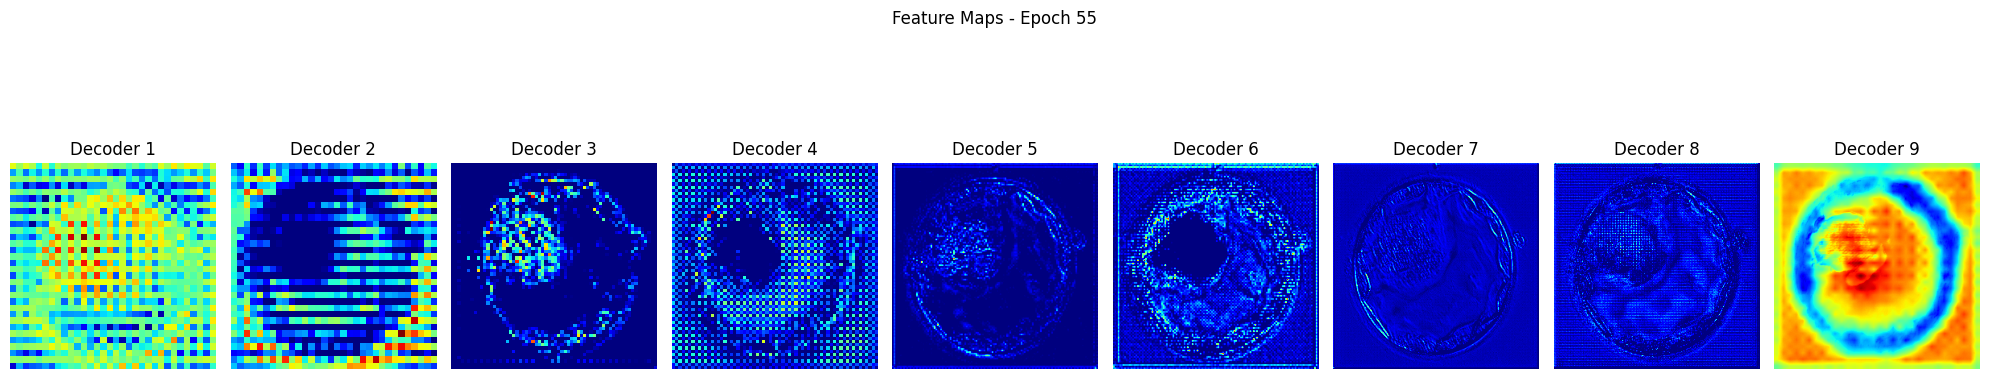

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9931 - dice_coef: 0.9565 - iou: 0.9173 - loss: 0.0434 - precision: 0.9592 - recall: 0.9546 - val_accuracy: 0.9778 - val_dice_coef: 0.8707 - val_iou: 0.7716 - val_loss: 0.1338 - val_precision: 0.8738 - val_recall: 0.8575 - learning_rate: 1.0000e-07
Epoch 56/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9927 - dice_coef: 0.9533 - iou: 0.9115 - loss: 0.0467 - precision: 0.9570 - recall: 0.9505 - val_accuracy: 0.9778 - val_dice_coef: 0.8709 - val_iou: 0.7719 - val_loss: 0.1336 - val_precision: 0.8743 - val_recall: 0.8575 - learning_rate: 1.0000e-07
Epoch 57/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9933 - dice_coef: 0.9586 - iou: 0.9211 - loss: 0.0414 - precision: 0.9615 - recall: 0.9565 - val_accuracy: 0.9778 - val_dice_coef: 0.8712 - val_iou: 0.7725 - val_loss: 0.1334 - val_precision: 0.8734 - val_recall: 0.8589 - learning_rate: 1.0000e-07
Epoch 58/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

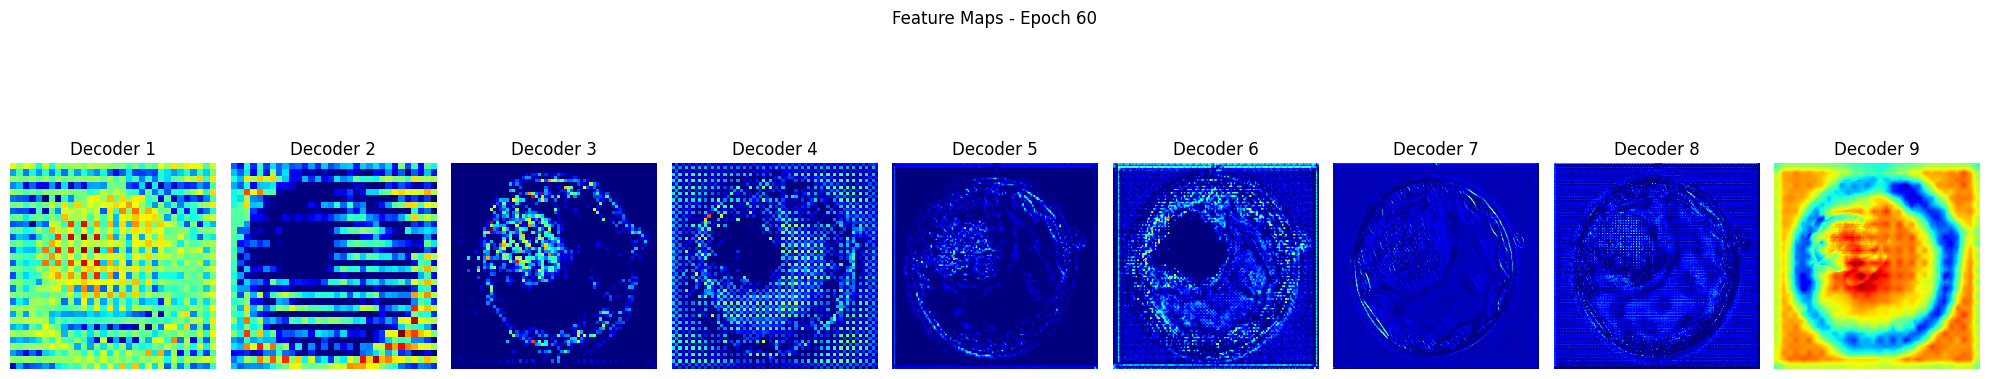

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9924 - dice_coef: 0.9524 - iou: 0.9098 - loss: 0.0476 - precision: 0.9565 - recall: 0.9493 - val_accuracy: 0.9778 - val_dice_coef: 0.8712 - val_iou: 0.7725 - val_loss: 0.1334 - val_precision: 0.8738 - val_recall: 0.8584 - learning_rate: 1.0000e-07
Epoch 61/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9929 - dice_coef: 0.9554 - iou: 0.9152 - loss: 0.0446 - precision: 0.9590 - recall: 0.9524 - val_accuracy: 0.9778 - val_dice_coef: 0.8709 - val_iou: 0.7719 - val_loss: 0.1337 - val_precision: 0.8744 - val_recall: 0.8573 - learning_rate: 1.0000e-07
Epoch 62/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9929 - dice_coef: 0.9552 - iou: 0.9148 - loss: 0.0448 - precision: 0.9579 - recall: 0.9532 - val_accuracy: 0.9778 - val_dice_coef: 0.8708 - val_iou: 0.7718 - val_loss: 0.1337 - val_precision: 0.8746 - val_recall: 0.8571 - learning_rate: 1.0000e-07
Epoch 63/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9

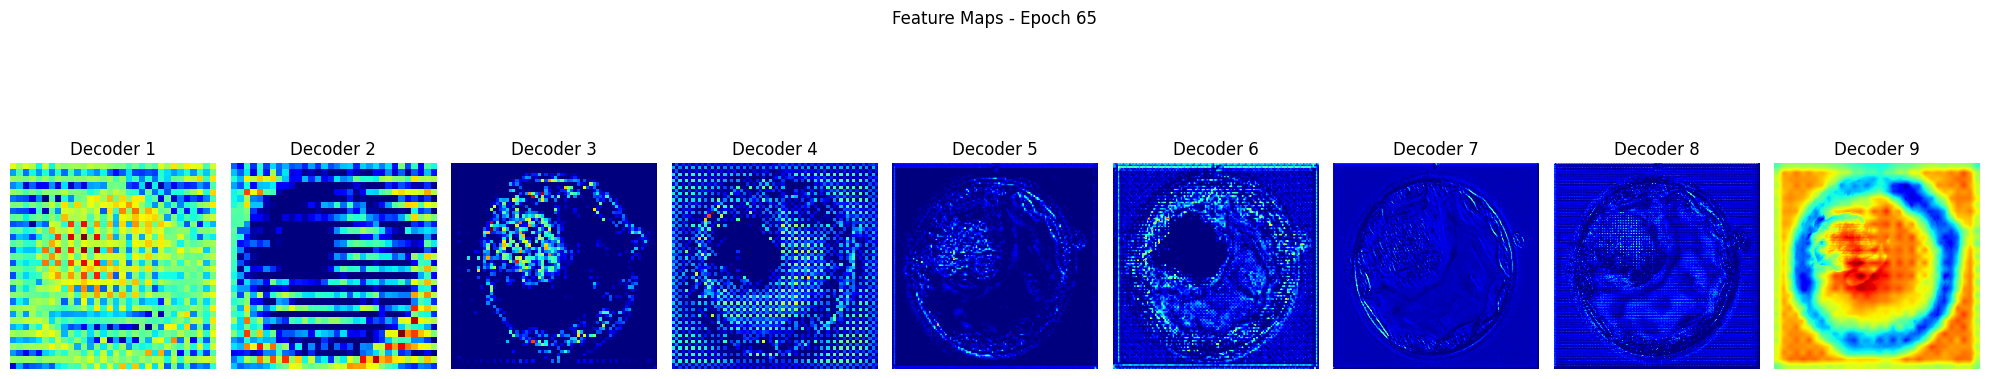

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9927 - dice_coef: 0.9544 - iou: 0.9135 - loss: 0.0456 - precision: 0.9568 - recall: 0.9532 - val_accuracy: 0.9779 - val_dice_coef: 0.8713 - val_iou: 0.7726 - val_loss: 0.1333 - val_precision: 0.8736 - val_recall: 0.8589 - learning_rate: 1.0000e-07
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9932 - dice_coef: 0.9574 - iou: 0.9188 - loss: 0.0426 - precision: 0.9606 - recall: 0.9550 - val_accuracy: 0.9778 - val_dice_coef: 0.8711 - val_iou: 0.7723 - val_loss: 0.1336 - val_precision: 0.8733 - val_recall: 0.8587 - learning_rate: 1.0000e-07
Epoch 67/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9928 - dice_coef: 0.9547 - iou: 0.9141 - loss: 0.0453 - precision: 0.9591 - recall: 0.9515 - val_accuracy: 0.9778 - val_dice_coef: 0.8710 - val_iou: 0.7721 - val_loss: 0.1336 - val_precision: 0.8737 - val_recall: 0.8581 - learning_rate: 1.0000e-07


In [23]:
modelicm_totale.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    callbacks=[callbacks,feature_map_callback],
)

In [24]:
modelicm_totale.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - accuracy: 0.9838 - dice_coef: 0.9002 - iou: 0.8187 - loss: 0.1014 - precision: 0.8730 - recall: 0.9247


[0.09933391213417053,
 0.9031181931495667,
 0.8234601020812988,
 0.9844799637794495,
 0.9269726872444153,
 0.8743727207183838]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


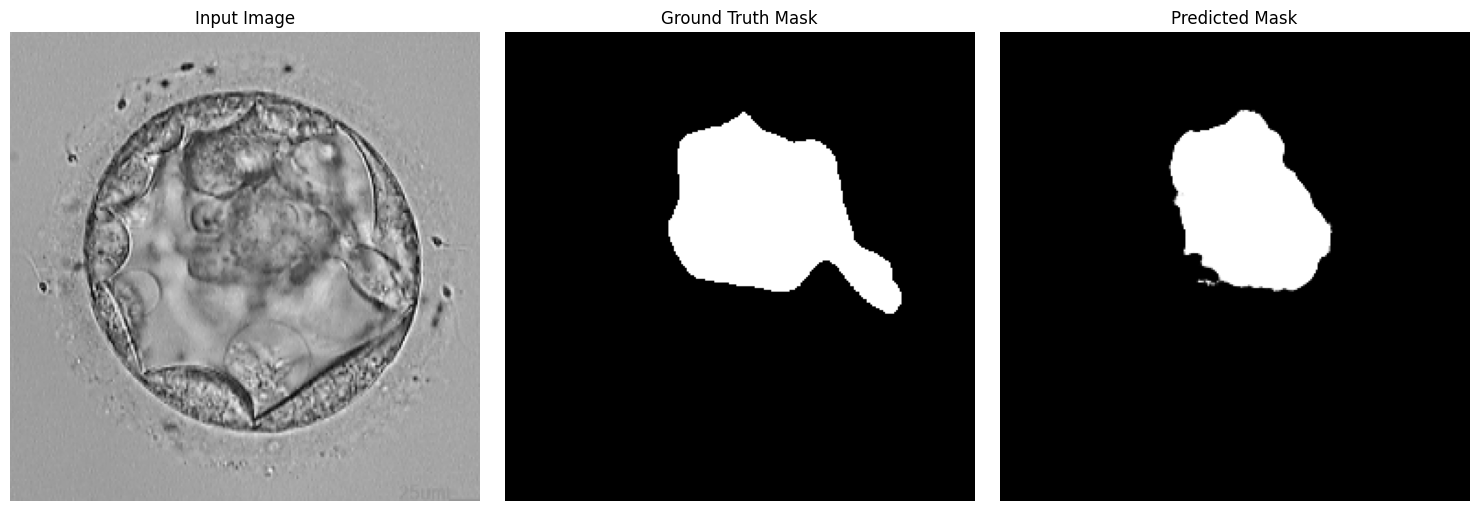

In [25]:

pred_dict = modelicm_totale.predict(sample_img_exp)
output = pred_dict[0]  

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
modelicm_totale.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 115,149,123 (439.26 MB)

 Trainable params: 38,376,939 (146.40 MB)

 Non-trainable params: 18,304 (71.50 KB)

 Optimizer params: 76,753,880 (292.79 MB)